---
## Notebook for `squential` power analysis of all 
* This notebook reads the data from the sequential analysis
* It has two main plots one for a single service and one for comparing two services
* All metrics can be plotted: `power`, `delta` and `energy` for all applications
* All figures are automatically saved in the directory `plots/`


---
### Read Data: Save Sequential Data to the `data_dict` Variable
* Reads the data from the `data/out` directory
* Saves the data to the `data_dict` variable

In [22]:
from wsgiref.util import application_uri

import pandas as pd
import os

SERVICES  = ['rust-actix', 'ruby-sinatra', 'go-gorilla', 'go-gin', 'python-flask', 'c-sharp-razor', 'javascript-express'] # rust-actix
base_dir = 'data/out'
dir_out = 'plots/'
data_dict = {}

def merge_with_power(df_api, df_page, df_power):
    """
    Merge both df_api and df_page with df_power sequentially.
    """
    # Ensure DataFrames are sorted by their time columns
    df_power = df_power.sort_values("timestamp")
    df_api = df_api.sort_values("start")
    df_page = df_page.sort_values("start")
    
    # Merge API data with power
    merged_api = pd.merge_asof(
        df_power,
        df_api,
        left_on="timestamp",
        right_on="start",
        direction="forward",
    )
    
    split_index = merged_api[merged_api['endpoint'].isna()].index.min()
    
    df_power_split = df_power.iloc[split_index:]
    
    # Merge Page data with the second half of df_power
    merged_page = pd.merge_asof(
        df_power_split,
        df_page,
        left_on="timestamp",
        right_on="start",
        direction="forward"
    )
    
    df_merged = pd.concat([merged_api, merged_page], ignore_index=True)
    df_merged = df_merged.dropna(subset=['endpoint'])
    return df_merged
    

for service in SERVICES:
    df_api, df_page, df_power = None, None, None

    service_dir = os.path.join(base_dir, service, 'sequential')
    if not os.path.exists(service_dir):
        print(f"Directory does not exist: {service_dir}")
        continue
    # iterates of files in service_dir    
    for file_name in os.listdir(service_dir):
        file_path = os.path.join(service_dir, file_name)
            
        # Read the CSV files based on their naming convention
        if file_name.endswith(".csv"):
            if "api" in file_name:
                df_api = pd.read_csv(file_path)
            elif "page" in file_name:
                df_page = pd.read_csv(file_path)
            elif "power" in file_name:
                df_power = pd.read_csv(file_path)
            
            if df_api is not None and df_page is not None and df_power is not None:
                df_service  = merge_with_power(df_api, df_page, df_power)
                df_service['endpoint'] = df_service['endpoint'].str.replace(r'/user\d+/unfollow', '/user/unfollow', regex=True) # make endpoint names consistent for page unfollow
                df_service['endpoint'] = df_service['endpoint'].str.replace(r'/user\d+/follow', '/user/follow', regex=True) # make endpoint names consistent for page follow
                df_service['endpoint'] = df_service['endpoint'].str.replace(r'/api/fllws/user\d+', '/api/fllws/user', regex=True) 
                df_service['endpoint'] = df_service['endpoint'].str.replace(r'/api/unfllw/user\d+', '/api/unfllws/user', regex=True) 
                df_service['energy'] = df_service['power'] * df_service['delta']
                data_dict[service] = df_service
            else:
                print("dataframe is empty, can't be merged")
        

dataframe is empty, can't be merged
dataframe is empty, can't be merged
dataframe is empty, can't be merged
dataframe is empty, can't be merged
dataframe is empty, can't be merged
dataframe is empty, can't be merged
dataframe is empty, can't be merged
dataframe is empty, can't be merged
dataframe is empty, can't be merged
dataframe is empty, can't be merged
dataframe is empty, can't be merged
dataframe is empty, can't be merged
dataframe is empty, can't be merged
dataframe is empty, can't be merged


In [23]:
# check applications in data_dict
print("applications in data_dict:")
print(data_dict.keys())
print("dataframe:")
data_dict['python-flask'].head()

applications in data_dict:
dict_keys(['rust-actix', 'ruby-sinatra', 'go-gorilla', 'go-gin', 'python-flask', 'c-sharp-razor', 'javascript-express'])
dataframe:


,timestamp,power,current,voltage,endpoint,response,start,end,delta,energy
0,1.734193e+09,2.940987,0.588161,5.000307,/api/register,204.0,1.734193e+09,1.734193e+09,0.461715,1.357897
1,1.734193e+09,2.943597,0.588713,5.000055,/api/register,204.0,1.734193e+09,1.734193e+09,0.461715,1.359102
2,1.734193e+09,2.944075,0.588778,5.000311,/api/register,204.0,1.734193e+09,1.734193e+09,0.461715,1.359323
3,1.734193e+09,2.944200,0.588761,5.000667,/api/register,204.0,1.734193e+09,1.734193e+09,0.461715,1.359381
4,1.734193e+09,2.943418,0.588585,5.000840,/api/register,204.0,1.734193e+09,1.734193e+09,0.461715,1.359020


---
### Helper functions for data pipline sequential analysis

In [24]:
import os
from datetime import datetime
import matplotlib as mpl

# Helper functions for data pipline sequential analysis
def customize_boxplot(bplot, colors, tick_color, median_color):
    """
    Helper function to customize the appearance
    """
    # Customize the box colors
    for patch, color in zip(bplot['boxes'], colors):
        patch.set(color=color, linewidth=1.5)  # Set box outline color and line width
        patch.set(facecolor=color, alpha=0.8)  # Fill the box with the specified color

    # Customize the whiskers
    for whisker in bplot['whiskers']:
        whisker.set(color=tick_color, linewidth=1.5)  # Set whisker color and line width

    # Customize the caps
    for cap in bplot['caps']:
        cap.set(color=tick_color, linewidth=1.5)  # Set cap color and line width

    # Customize the medians
    for median in bplot['medians']:
        median.set(color=median_color, linewidth=1.5)  # Set median line color
        
        
def save_plot(fig, weact_service, plot_type="sequential", filename_suffix="energy"):
    """
    Save a plot to a specific directory with a timestamped filename.
    """
    vector_format = "pdf"
    if plot_type == "compare-sequential":
        dir_out = f'plots/{plot_type}'
    else:
        dir_out = f'plots/{weact_service}/{plot_type}'
    
    current_time = datetime.now().strftime("%Y-%m-%d_%H:%M")  # Format: YYYY-MM-DD_HH
    
    # reduce size
    mpl.rcParams['path.simplify'] = True
    mpl.rcParams['path.simplify_threshold'] = 0.1  
    
    # Create the directory if it doesn't exist
    os.makedirs(dir_out, exist_ok=True)
    
    # Save the figure
    fig.savefig(
        os.path.join(dir_out, f"{weact_service}_{filename_suffix}.{vector_format}"),
        bbox_inches='tight',
        dpi=100,
        facecolor='white',
        format='pdf'
    )
    print(f"Plot for {weact_service} ({plot_type}) saved as {filename_suffix} at {dir_out}")
    

def define_title_xlable_ylable(analyse):
    """
    Define title, x-label and y-label based on the comparison of
    :param comparison_of: 
    :return: 
    """
    if analyse == 'power':
        title = 'Power Consumption by Endpoint'
        y_label = 'Power (W)'
    elif analyse == 'delta':
        title = 'Execution Time by Endpoint'
        y_label = 'Execution Time'
    else:
        title = 'Energy Consumption by Endpoint'
        y_label = 'Energy (J)'
    x_label = 'Endpoints'
    return title, x_label, y_label


---
### Boxplot: Plot `power`, `delta` or `energy` for all `endpoints` for a single service
* plots the defined metric for all endpoints for a single service

In [25]:
import matplotlib.pyplot as plt

def plot_service_metric_boxplot(data_dict, weact_service, metric='power', y_axis_limits=None):
    """
    Plot a boxplot for a specific metric of a given service with custom styles.

    Parameters:
    - data_dict (dict): Dictionary containing the data grouped by services.
    - weact_service (str): The service to plot.
    - metric (str): The metric to plot (e.g., 'power').
    - y_axis_limits (tuple): Optional y-axis limits for the plot (e.g., (2.8, 3.5)).
    """
    labels_fontsize = 11
    labels_fontcolor = "#2A2A2A"
    title_fontsize = 12
    tick_color = "#5D5D5D"
    colors = ['#2933EB']
    median_color = "#EB4532"

    # Customize flier properties for outliers
    flierprops = {
        'marker': 'o',
        'markerfacecolor': '#D7B0FF',
        'markeredgecolor': '#978AB5',
        'markersize': 2,
        'linestyle': 'none',
        'alpha': 0.2,
    }

    # Get unique endpoints and prepare grouped data for boxplot
    labels = list(data_dict[weact_service]['endpoint'].unique())  # Unique endpoints
    grouped_data_metric = [
        data_dict[weact_service][data_dict[weact_service]['endpoint'] == endpoint][metric]
        for endpoint in labels
    ]

    # Plotting
    fig, ax = plt.subplots(figsize=(14, 8), facecolor='white')
    ax.set_facecolor('#F9F9F9')
    
    # Box plot with custom styles
    bplot = ax.boxplot(grouped_data_metric, labels=labels, patch_artist=True, flierprops=flierprops, widths=0.5)
    # raster fliers
    for line in bplot['fliers']:
        line.set_rasterized(True)

    # Customize the appearance of the box plot
    customize_boxplot(bplot, colors * len(labels), tick_color, median_color)

    # Set title and labels
    title, x_label, y_label = define_title_xlable_ylable(metric)
    ax.set_title(f'{title} – {weact_service}', color=labels_fontcolor, fontsize=title_fontsize)
    ax.set_ylabel(f'{y_label}', color=labels_fontcolor, fontsize=labels_fontsize)
    ax.set_xlabel(f'{x_label}', color=labels_fontcolor, fontsize=labels_fontsize)

    # Adjust the tick parameters for better visibility
    ax.tick_params(labelsize=labels_fontsize, color=tick_color, labelcolor=tick_color)
    ax.tick_params(axis='x', labelsize=labels_fontsize, rotation=45, labelcolor=tick_color)

    # Add grid for readability
    ax.grid(True, linestyle='dotted', linewidth=1.0, color=tick_color)
    ax.autoscale(enable=True, axis="y", tight=False)

    # Optionally set y-axis limits for better visualization
    if y_axis_limits:
        ax.set_ylim(y_axis_limits)

    # Show the plot
    plt.tight_layout()
    plt.show()
    return fig

/var/folders/gb/tnf1yptj0gl7g0718ztgp6340000gn/T/ipykernel_45109/2704880442.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(grouped_data_metric, labels=labels, patch_artist=True, flierprops=flierprops, widths=0.5)


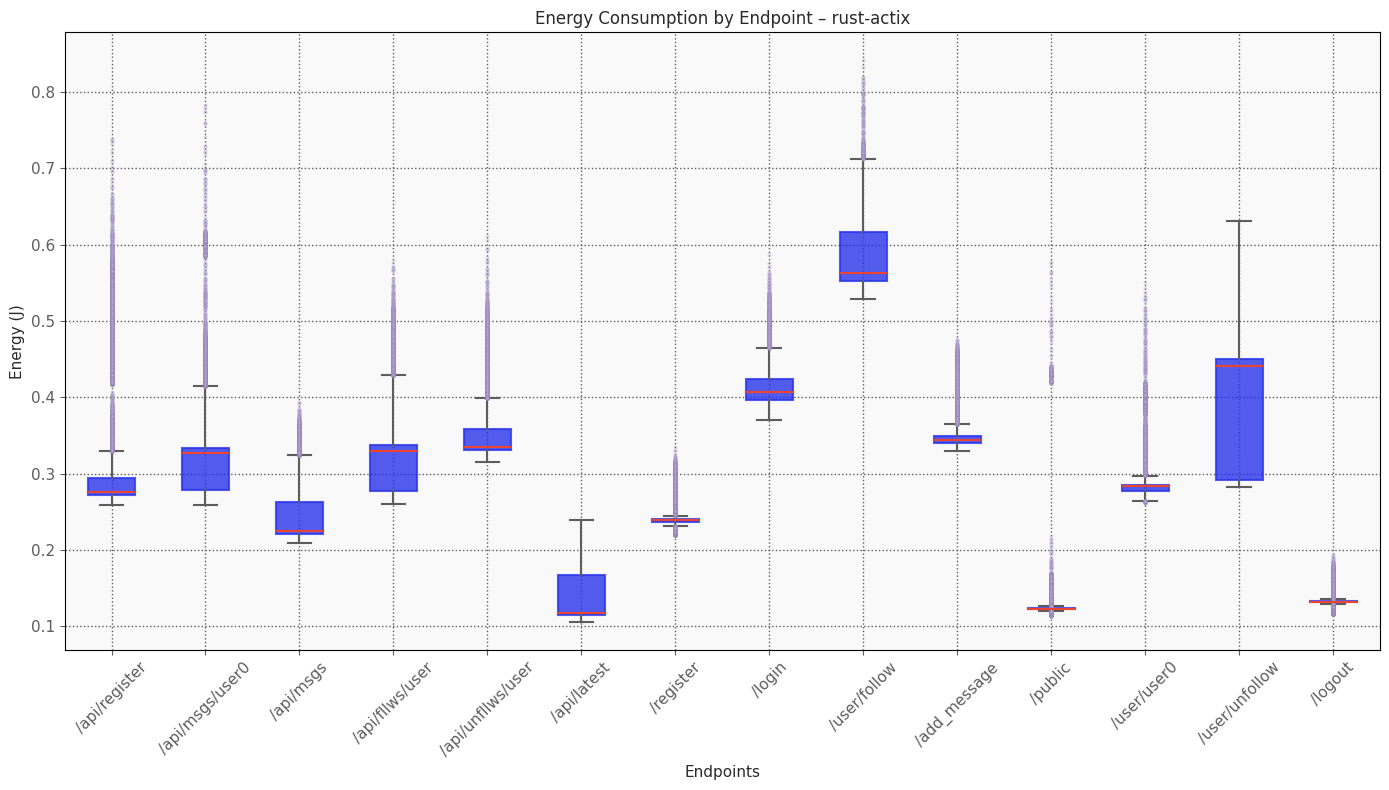

In [26]:
# plot all endpoints for python-flask application
application = 'rust-actix'
metric = 'energy'
fig = plot_service_metric_boxplot(
        data_dict=data_dict,
        weact_service=application,
        metric=metric
        # y_axis_limits=(2.8, 3.5)  # Optional, can be omitted
      )

In [27]:
# save the plot
save_plot(fig, application, plot_type="sequential", filename_suffix=metric)

Plot for rust-actix (sequential) saved as energy at plots/rust-actix/sequential


/var/folders/gb/tnf1yptj0gl7g0718ztgp6340000gn/T/ipykernel_45109/2704880442.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(grouped_data_metric, labels=labels, patch_artist=True, flierprops=flierprops, widths=0.5)


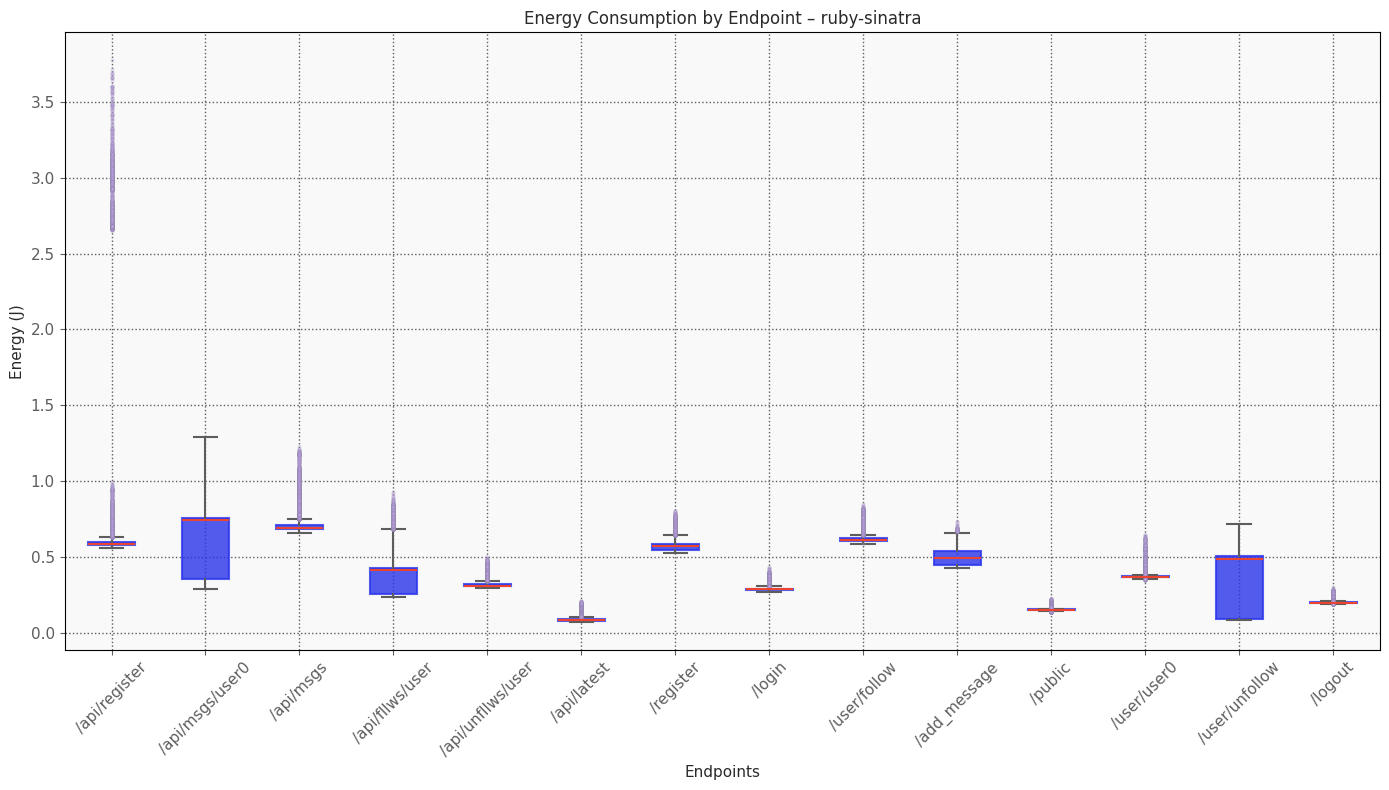

In [28]:
# plot all endpoints for python-flask application
application = 'ruby-sinatra'
fig = plot_service_metric_boxplot(
        data_dict=data_dict,
        weact_service=application,
        metric=metric
        # y_axis_limits=(2.8, 3.5)  # Optional, can be omitted
      )

---
### Boxplot: Plots all `metrics` for all `endpoints` and makes comparison for two defined services
* Define two services to compare
* Define the metric to compare

In [29]:
save_plot(fig, f'{application}', plot_type="sequential", filename_suffix=metric)

Plot for ruby-sinatra (sequential) saved as energy at plots/ruby-sinatra/sequential


/var/folders/gb/tnf1yptj0gl7g0718ztgp6340000gn/T/ipykernel_45109/2704880442.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(grouped_data_metric, labels=labels, patch_artist=True, flierprops=flierprops, widths=0.5)


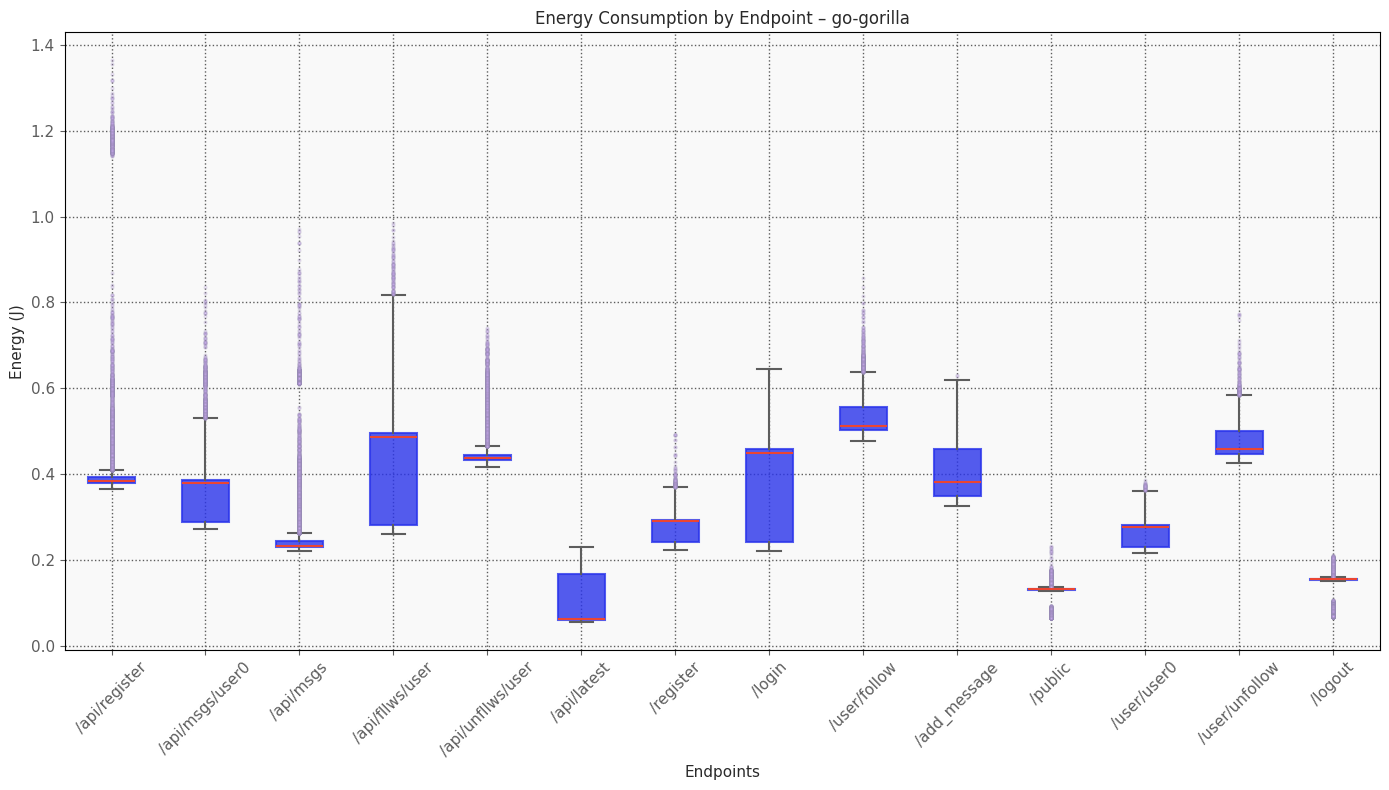

In [30]:
# plot all endpoints for go-gorilla application
application = 'go-gorilla'
fig = plot_service_metric_boxplot(
        data_dict=data_dict,
        weact_service=application,
        metric=metric
        # y_axis_limits=(2.8, 3.5)  # Optional, can be omitted
      )

In [31]:
save_plot(fig, f'{application}', plot_type="sequential", filename_suffix=metric)


Plot for go-gorilla (sequential) saved as energy at plots/go-gorilla/sequential


/var/folders/gb/tnf1yptj0gl7g0718ztgp6340000gn/T/ipykernel_45109/2704880442.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(grouped_data_metric, labels=labels, patch_artist=True, flierprops=flierprops, widths=0.5)


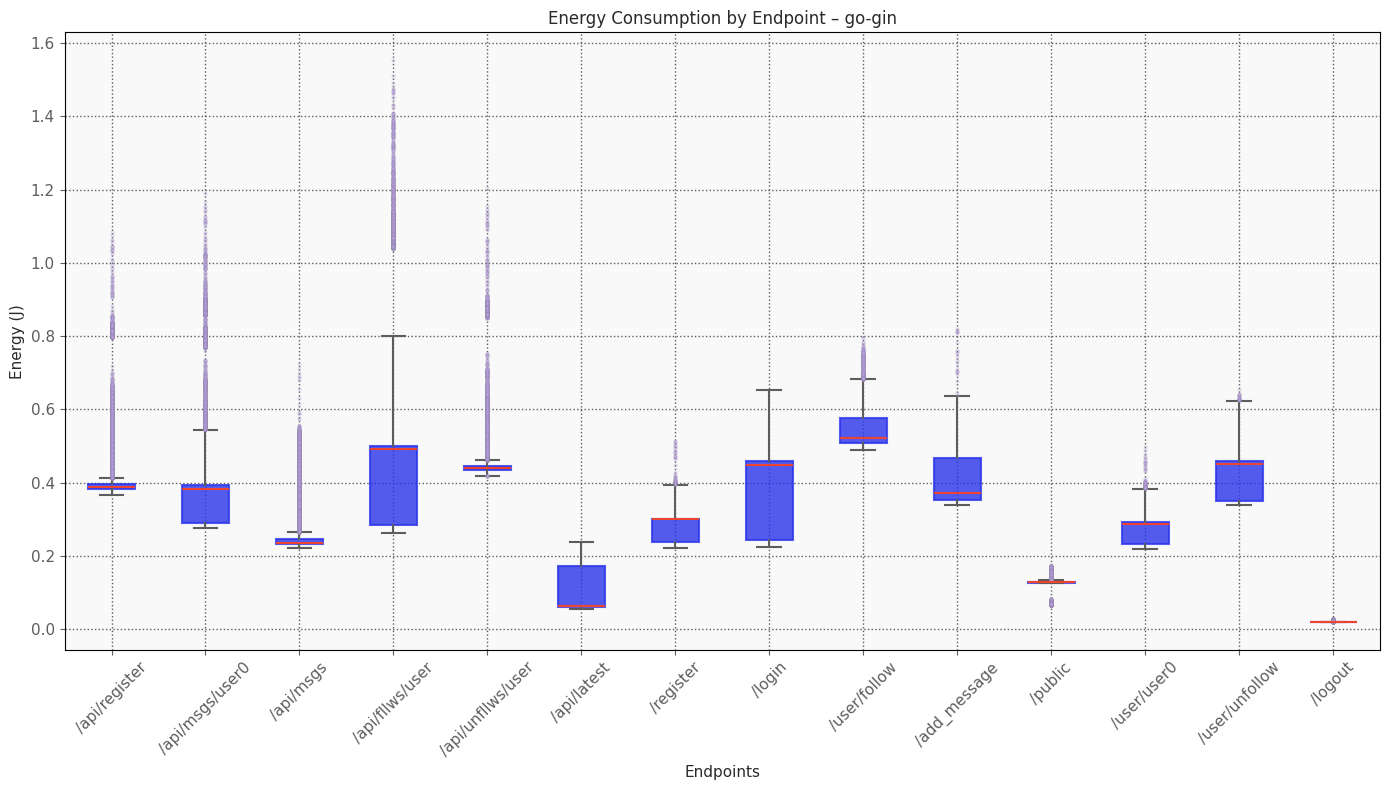

In [32]:
# plot all endpoints for go-gin application
application = 'go-gin'
fig = plot_service_metric_boxplot(
        data_dict=data_dict,
        weact_service=application,
        metric=metric
        # y_axis_limits=(2.8, 3.5)  # Optional, can be omitted
      )

In [33]:
save_plot(fig, f'{application}', plot_type="sequential", filename_suffix=metric)

Plot for go-gin (sequential) saved as energy at plots/go-gin/sequential


/var/folders/gb/tnf1yptj0gl7g0718ztgp6340000gn/T/ipykernel_45109/2704880442.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(grouped_data_metric, labels=labels, patch_artist=True, flierprops=flierprops, widths=0.5)


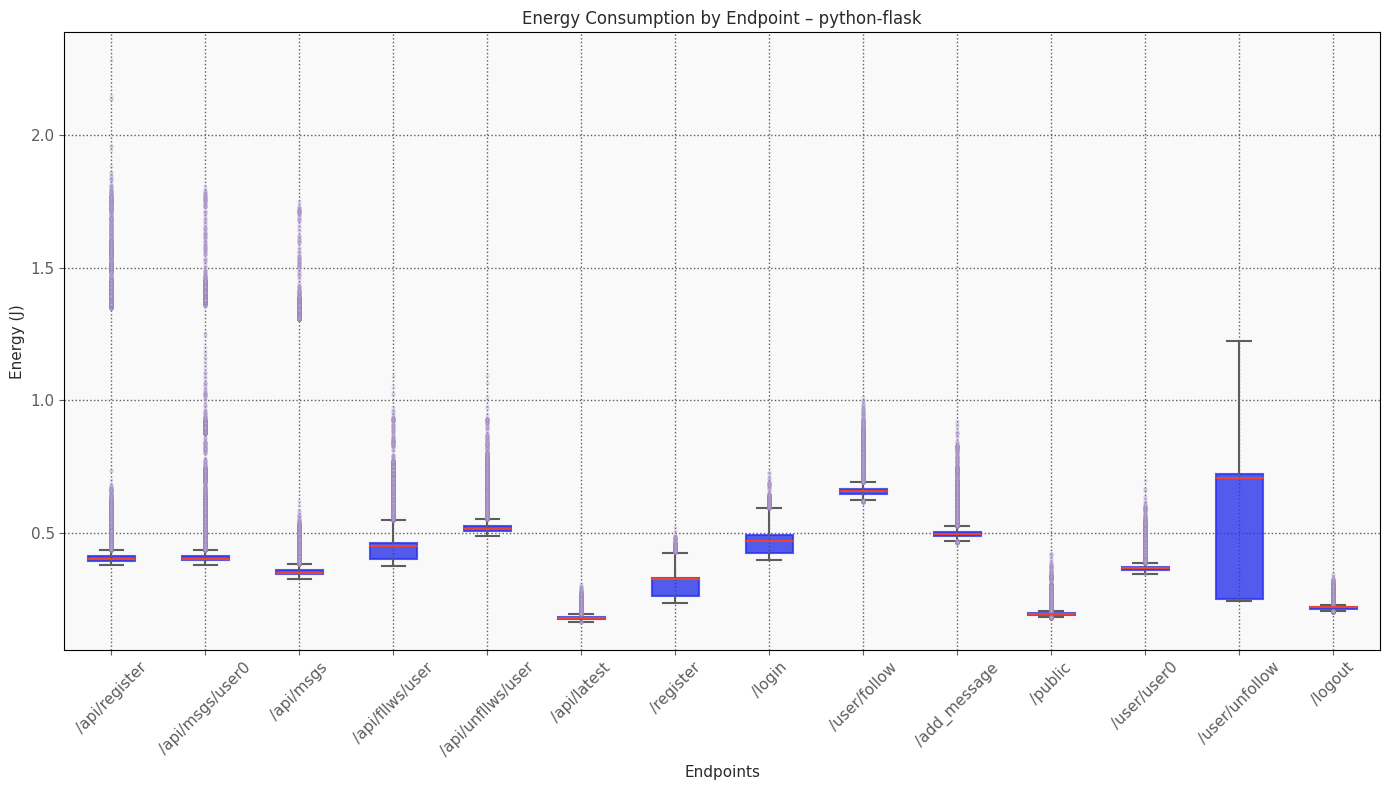

In [34]:
# plot all endpoints for python-flask application
application = 'python-flask'
fig = plot_service_metric_boxplot(
        data_dict=data_dict,
        weact_service=application,
        metric=metric
        # y_axis_limits=(2.8, 3.5)  # Optional, can be omitted
      )

In [35]:
save_plot(fig, f'{application}', plot_type="sequential", filename_suffix=metric)

Plot for python-flask (sequential) saved as energy at plots/python-flask/sequential


/var/folders/gb/tnf1yptj0gl7g0718ztgp6340000gn/T/ipykernel_45109/2704880442.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(grouped_data_metric, labels=labels, patch_artist=True, flierprops=flierprops, widths=0.5)


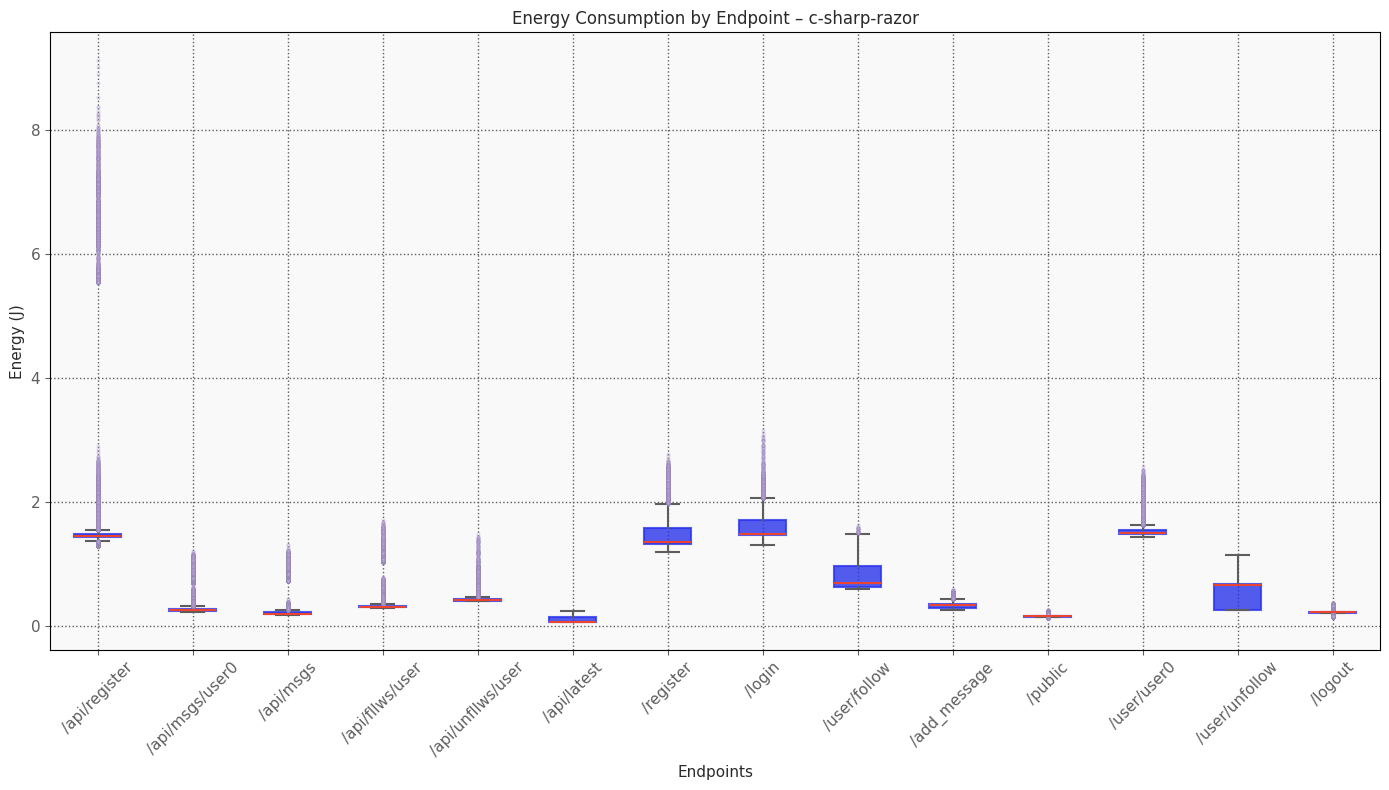

In [36]:
# plot all endpoints for c-sharp-razor application
application = 'c-sharp-razor'
fig = plot_service_metric_boxplot(
        data_dict=data_dict,
        weact_service=application,
        metric=metric
        # y_axis_limits=(2.8, 3.5)  # Optional, can be omitted
      )

In [37]:
save_plot(fig, f'{application}', plot_type="sequential", filename_suffix=metric)

Plot for c-sharp-razor (sequential) saved as energy at plots/c-sharp-razor/sequential


/var/folders/gb/tnf1yptj0gl7g0718ztgp6340000gn/T/ipykernel_45109/2704880442.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(grouped_data_metric, labels=labels, patch_artist=True, flierprops=flierprops, widths=0.5)


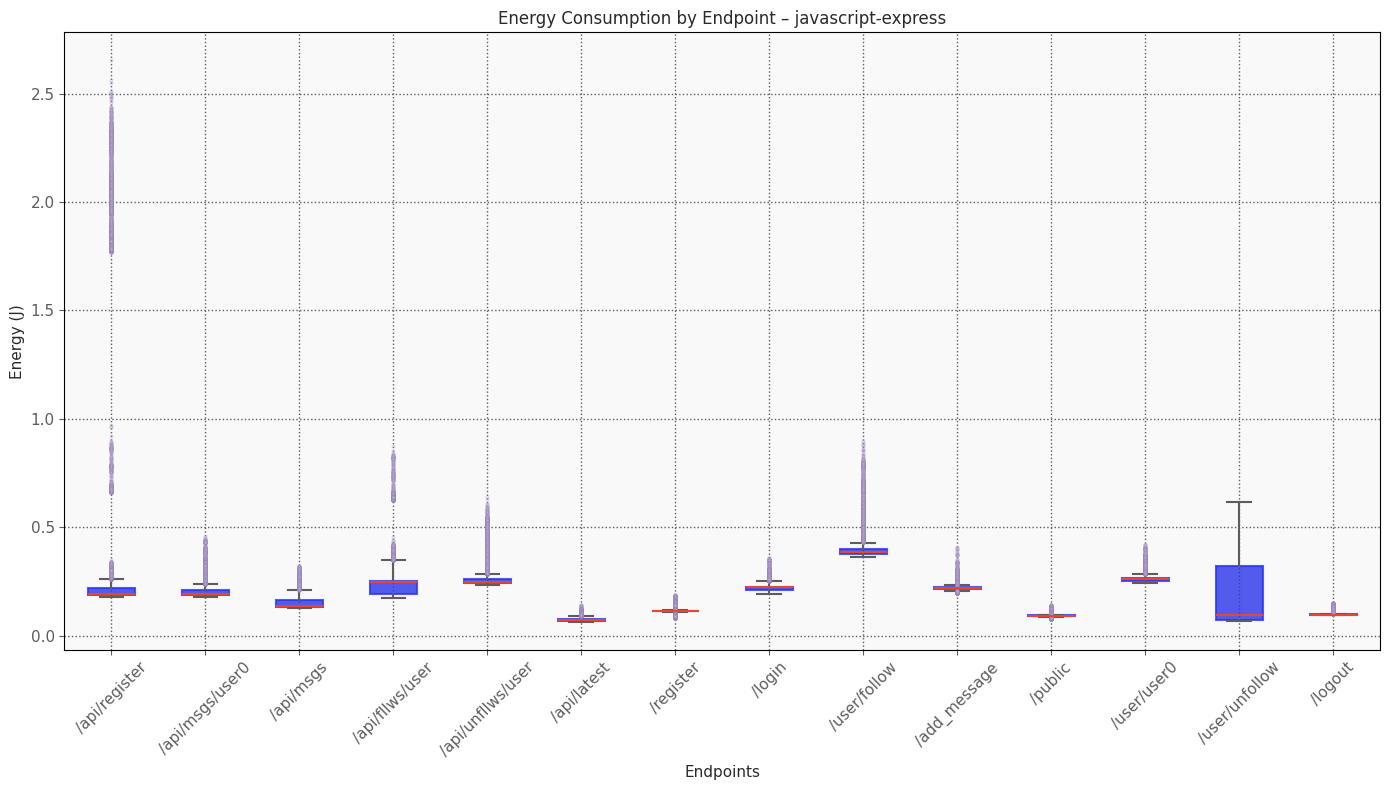

In [38]:
# plot all endpoints for javascript-express application
application = 'javascript-express'
fig = plot_service_metric_boxplot(
        data_dict=data_dict,
        weact_service=application,
        metric=metric
        # y_axis_limits=(2.8, 3.5)  # Optional, can be omitted
      )

In [39]:
save_plot(fig, f'{application}', plot_type="sequential", filename_suffix=metric)

Plot for javascript-express (sequential) saved as energy at plots/javascript-express/sequential


In [40]:
# final table for all applications for all endpoints - power
from matplotlib.cbook import boxplot_stats

final_results_power = []

for service in SERVICES:
    if service not in data_dict:
        print(f"No data for service: {service}")
        continue
        
    df_service = data_dict[service]
    grouped = df_service.groupby('endpoint')['power']
    
    for endpoint, power_series in grouped:
        stats = boxplot_stats(power_series)

        q0 = stats[0]['whislo']  # Lower whisker
        q4 = stats[0]['whishi']  # Upper whisker
        q1 = stats[0]['q1']      # First quartile
        q3 = stats[0]['q3']      # Third quartile
        median = stats[0]['med'] # Median
        mean = power_series.mean() # Mean for this group
        std = power_series.std()   # Std for this group
        
        statistics = {
            "endpoint": endpoint,
            "min (q0)": round(q0, 3),
            "q1": round(q1, 3),
            "median (q2)": round(median, 3),
            "q3": round(q3, 3),
            "max (q4)": round(q4, 3),
            "mean (μ)": round(mean, 3),
            "std (σ)": round(std, 3),
            "application": service
        }
        
        final_results_power.append(statistics)

final_results_df = pd.DataFrame(final_results_power)
final_results_df = final_results_df.sort_values(by='endpoint').reset_index(drop=True)
print(final_results_df)

        endpoint  min (q0)     q1  median (q2)     q3  max (q4)  mean (μ)  \
0   /add_message     2.905  2.933        2.943  2.952     2.980     2.966   
1   /add_message     2.924  2.972        2.984  3.005     3.053     3.031   
2   /add_message     2.951  2.997        3.011  3.029     3.075     3.065   
3   /add_message     2.941  3.022        3.035  3.346     3.833     3.197   
4   /add_message     2.934  2.960        2.971  2.978     3.004     2.992   
..           ...       ...    ...          ...    ...       ...       ...   
93   /user/user0     2.936  2.962        2.973  2.980     3.006     2.997   
94   /user/user0     2.920  2.960        2.971  2.987     3.027     3.012   
95   /user/user0     2.934  2.973        2.984  2.998     3.037     3.023   
96   /user/user0     2.926  2.960        2.972  2.984     3.018     3.002   
97   /user/user0     2.960  2.999        3.011  3.025     3.064     3.060   

    std (σ)         application  
0     0.116          rust-actix  
1     0

In [41]:
# save table power to csv descriptive statistics table
final_results_df.to_csv('./result_tables/sequential/descr_stats_all_end_nd_apps_power.csv', index=False, sep=';')

In [42]:
# final table for all applications for all endpoints - delta
final_results_power = []

for service in SERVICES:
    if service not in data_dict:
        print(f"No data for service: {service}")
        continue
        
    df_service = data_dict[service]
    grouped = df_service.groupby('endpoint')['delta']
    
    for endpoint, power_series in grouped:
        stats = boxplot_stats(power_series)

        q0 = stats[0]['whislo']  # Lower whisker
        q4 = stats[0]['whishi']  # Upper whisker
        q1 = stats[0]['q1']      # First quartile
        q3 = stats[0]['q3']      # Third quartile
        median = stats[0]['med'] # Median
        mean = power_series.mean() # Mean for this group
        std = power_series.std()   # Std for this group
        
        statistics = {
            "endpoint": endpoint,
            "min (q0)": round(q0, 3),
            "q1": round(q1, 3),
            "median (q2)": round(median, 3),
            "q3": round(q3, 3),
            "max (q4)": round(q4, 3),
            "mean (μ)": round(mean, 3),
            "std (σ)": round(std, 3),
            "application": service
        }
        
        final_results_power.append(statistics)

final_results_df = pd.DataFrame(final_results_power)
final_results_df = final_results_df.sort_values(by='endpoint').reset_index(drop=True)
print(final_results_df)

        endpoint  min (q0)     q1  median (q2)     q3  max (q4)  mean (μ)  \
0   /add_message     0.115  0.115        0.117  0.119     0.120     0.117   
1   /add_message     0.148  0.151        0.153  0.180     0.180     0.163   
2   /add_message     0.073  0.073        0.073  0.073     0.073     0.072   
3   /add_message     0.088  0.094        0.115  0.115     0.115     0.105   
4   /add_message     0.113  0.117        0.124  0.154     0.154     0.135   
..           ...       ...    ...          ...    ...       ...       ...   
93   /user/user0     0.075  0.077        0.095  0.095     0.095     0.087   
94   /user/user0     0.120  0.122        0.124  0.124     0.126     0.125   
95   /user/user0     0.122  0.123        0.123  0.124     0.125     0.125   
96   /user/user0     0.076  0.078        0.098  0.098     0.098     0.089   
97   /user/user0     0.083  0.083        0.088  0.088     0.092     0.086   

    std (σ)         application  
0     0.002          rust-actix  
1     0

In [43]:
# save table delta to csv
final_results_df.to_csv('./result_tables/sequential/descr_stats_all_nd_apps_delta.csv', index=False, sep=';')

In [44]:
# final table for all applications for all endpoints - energy
final_results_power = []

for service in SERVICES:
    if service not in data_dict:
        print(f"No data for service: {service}")
        continue
        
    df_service = data_dict[service]
    grouped = df_service.groupby('endpoint')['energy']
    
    for endpoint, power_series in grouped:
        stats = boxplot_stats(power_series)

        q0 = stats[0]['whislo']  # Lower whisker
        q4 = stats[0]['whishi']  # Upper whisker
        q1 = stats[0]['q1']      # First quartile
        q3 = stats[0]['q3']      # Third quartile
        median = stats[0]['med'] # Median
        mean = power_series.mean() # Mean for this group
        std = power_series.std()   # Std for this group
        
        statistics = {
            "endpoint": endpoint,
            "min (q0)": round(q0, 3),
            "q1": round(q1, 3),
            "median (q2)": round(median, 3),
            "q3": round(q3, 3),
            "max (q4)": round(q4, 3),
            "mean (μ)": round(mean, 3),
            "std (σ)": round(std, 3),
            "application": service
        }
        
        final_results_power.append(statistics)

final_results_df = pd.DataFrame(final_results_power)
final_results_df = final_results_df.sort_values(by='endpoint').reset_index(drop=True)
print(final_results_df)

        endpoint  min (q0)     q1  median (q2)     q3  max (q4)  mean (μ)  \
0   /add_message     0.329  0.340        0.345  0.350     0.365     0.347   
1   /add_message     0.428  0.451        0.492  0.537     0.662     0.494   
2   /add_message     0.204  0.215        0.219  0.223     0.234     0.222   
3   /add_message     0.263  0.293        0.343  0.348     0.432     0.335   
4   /add_message     0.326  0.348        0.381  0.459     0.620     0.403   
..           ...       ...    ...          ...    ...       ...       ...   
93   /user/user0     0.216  0.230        0.277  0.282     0.360     0.260   
94   /user/user0     0.348  0.363        0.368  0.373     0.388     0.375   
95   /user/user0     0.355  0.366        0.368  0.373     0.384     0.378   
96   /user/user0     0.219  0.232        0.287  0.293     0.384     0.268   
97   /user/user0     0.243  0.251        0.262  0.264     0.283     0.263   

    std (σ)         application  
0     0.015          rust-actix  
1     0

In [45]:
# save table delta to csv
final_results_df.to_csv('./result_tables/sequential/descr_stats_all_end_nd_apps_energy.csv', index=False, sep=';')

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# plot for comparison of two applications

# Split endpoints into API and page
def split_endpoints(endpoints):
    api_endpoints = [e for e in endpoints if 'api' in e]
    page_endpoints = [e for e in endpoints if 'api' not in e]
    return api_endpoints, page_endpoints

# Helper to prepare grouped data
def prepare_grouped_data(endpoints, metric, services):
    grouped_data = []
    labels = []
    for endpoint in endpoints:
        for service in services:
            df_service = data_dict[service]
            if metric == 'energy':
                service_metric_data = df_service[df_service['endpoint'] == endpoint][metric]
                # service_metric_data = df_service.groupby('endpoint')['cumulative_energy'].last()
            elif metric == 'delta':
                service_metric_data = df_service[df_service['endpoint'] == endpoint][metric]
            else:
                service_metric_data = df_service[df_service['endpoint'] == endpoint][metric]
            grouped_data.append(service_metric_data)
            labels.append(f"{service} — {endpoint}")
    return grouped_data, labels

# Plot function
def plot_comparison(grouped_data, labels, group_colors, legend_labels, title):
    fig, ax = plt.subplots(figsize=(18, 8), facecolor='white')
    ax.set_facecolor('#F9F9F9')
    
    flierprops = {
        'marker': 'o',
        'markerfacecolor': '#D7B0FF',
        'markeredgecolor': '#978AB5',
        'markersize': 5,
        'alpha': 0.4,
    }   
    
    bplot = ax.boxplot(
        grouped_data,
        patch_artist=True,
        widths=0.4,
        labels=labels,
        flierprops=flierprops
    )
    # raster fliers
    for line in bplot['fliers']:
        line.set_rasterized(True)

    for i, patch in enumerate(bplot['boxes']):
        patch.set(facecolor=group_colors[i % 2], alpha=0.8)
        patch.set(color=group_colors[i % 2], linewidth=1.5)
        patch.set(linewidth=1.5)
    
    title, x_label, y_label = define_title_xlable_ylable(metric)
    ax.set_title(f'{title}', color=labels_fontcolor, fontsize=title_fontsize)
    ax.set_ylabel(f'{y_label}', color=labels_fontcolor, fontsize=title_fontsize)
    ax.set_xlabel(f'{x_label}', color=labels_fontcolor, fontsize=title_fontsize)
    
    # Customize tick labels
    ax.tick_params(axis='x', labelsize=12, rotation=90, labelcolor='#5D5D5D')
    ax.tick_params(axis='y', labelsize=12, labelcolor='#5D5D5D')
    
    # Add legend
    handles = [plt.Rectangle((0, 0), 1, 1, color=color, alpha=0.8) for color in group_colors]
    ax.legend(handles, legend_labels, loc='upper right', fontsize=10)

    plt.grid(True, linestyle='dotted')
    plt.tight_layout()
    plt.show()
    return fig


In [47]:
# prepare plot
services = ['javascript-express', 'python-flask']  # Define services to compare
metric = 'energy'  # Define the metric to compare - possible values: power, delta, energy
endpoints = data_dict['python-flask']['endpoint'].unique() # define one service where all endpoints are available
group_colors = ['#2933EB', '#993200']

# Define available endpoints
endpoints = data_dict['python-flask']['endpoint'].unique()
api_endpoints, page_endpoints = split_endpoints(endpoints)

# Prepare data for API and page endpoints
api_grouped_data, api_labels = prepare_grouped_data(api_endpoints, metric, services)
page_grouped_data, page_labels = prepare_grouped_data(page_endpoints, metric, services)

/var/folders/gb/tnf1yptj0gl7g0718ztgp6340000gn/T/ipykernel_45109/506092689.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(


NameError: name 'labels_fontcolor' is not defined

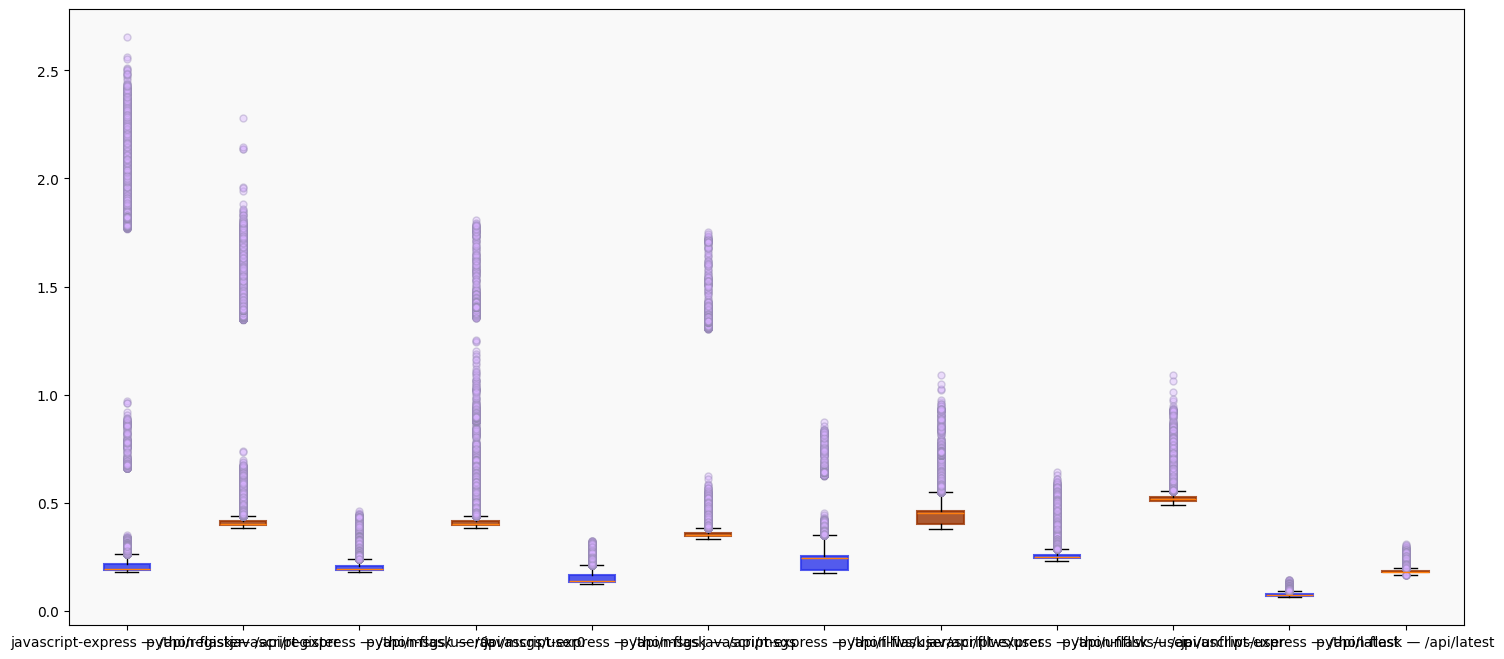

In [48]:
# Plot for API Endpoints
fig = plot_comparison(api_grouped_data, api_labels, ['#2933EB', '#993200'], services, "Comparison of API Endpoints")

In [213]:
# save fig
save_plot(fig, f'{"_".join(services)}_boxplot', plot_type="compare-sequential", filename_suffix=metric)

Plot for javascript-express_python-flask_boxplot (compare-sequential) saved as energy at plots/compare-sequential


/var/folders/gb/tnf1yptj0gl7g0718ztgp6340000gn/T/ipykernel_86680/3075001633.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(


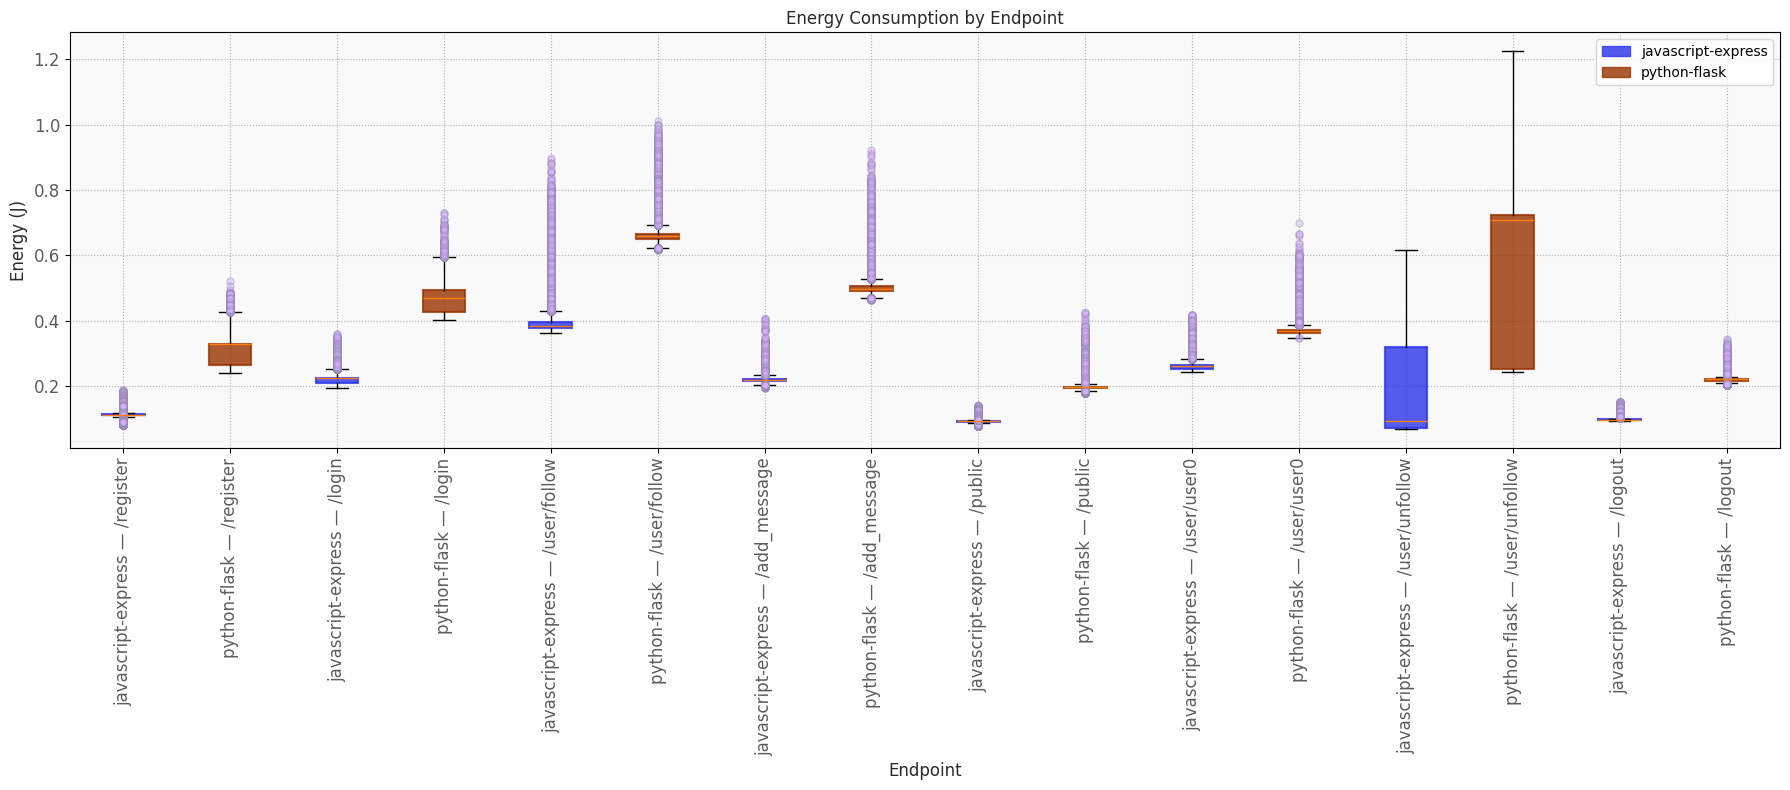

In [214]:
# Plot for Page Endpoints
fig = plot_comparison(page_grouped_data, page_labels, ['#2933EB', '#993200'], services, "Comparison of Page Endpoints")

In [215]:
# save fig
save_plot(fig, f'{"_".join(services)}_boxplot', plot_type="compare-sequential", filename_suffix=metric)

Plot for javascript-express_python-flask_boxplot (compare-sequential) saved as energy at plots/compare-sequential
